In [1]:
import pandas as pd

df = pd.DataFrame({
    'team':['Germany','USA','France','Japan','Sweden','England','Brazil','Canada','Australia','Norway','Netherlands','Spain',
           'China','New Zealand','South Korea','Switzerland','Mexico','Colombia','Thailand','Nigeria','Ecuador','Ivory Coast','Cameroon','Costa Rica'],
    'group':['B','D','F','C','D','F','E','A','D','B','A','E','A','A','E','C','F','F','B','D','C','B','C','E'],
    'fifascore':[2168,2158,2103,2066,2008,2001,1984,1969,1968,1933,1919,1867,1847,1832,1830,1813,1748,1692,1651,1633,1485,1373,1455,1589],
    'ftescore':[95.6,95.4,92.4,92.7,91.6,89.6,92.2,90.1,88.7,88.7,86.2,84.7,85.2,82.5,84.3,83.7,81.1,78.0,68.0,85.7,63.3,75.6,79.3,72.8]
    })

df.groupby(['group', 'team']).mean()

fifascore  ftescore
group team                            
A     Canada            1969      90.1
      China             1847      85.2
      Netherlands       1919      86.2
      New Zealand       1832      82.5
B     Germany           2168      95.6
      Ivory Coast       1373      75.6
      Norway            1933      88.7
      Thailand          1651      68.0
C     Cameroon          1455      79.3
      Ecuador           1485      63.3
      Japan             2066      92.7
      Switzerland       1813      83.7
D     Australia         1968      88.7
      Nigeria           1633      85.7
      Sweden            2008      91.6
      USA               2158      95.4
E     Brazil            1984      92.2
      Costa Rica        1589      72.8
      South Korea       1830      84.3
      Spain             1867      84.7
F     Colombia          1692      78.0
      England           2001      89.6
      France            2103      92.4
      Mexico            1748      81.1

In [2]:
df.index = df.team
df.describe()
#using 220 as std

,fifascore,ftescore
count,24.000000,24.00000
mean,1837.166667,84.47500
std,220.425018,8.34627
min,1373.000000,63.30000
25%,1681.750000,80.65000
50%,1857.000000,85.45000
75%,1988.250000,90.47500
max,2168.000000,95.60000


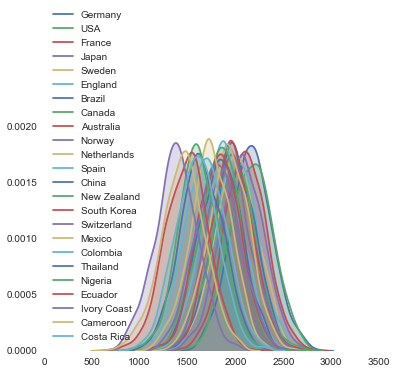

In [3]:
import scipy.stats as stats
import seaborn as sns
%matplotlib inline

for i in range(len(df)):        
    normdist = stats.norm(df.fifascore[i], 220)
    sns.kdeplot(normdist.rvs(1000), shade=True, label=df.team[i])

In [5]:
# http://stackoverflow.com/questions/30606566/generate-pairings-within-world-cup-tournament-groups
import itertools

# pd.DataFrame({grp: tuple(itertools.combinations(team, 2)) for grp, team in df.groupby('group')['team']})

matchlist = {}

for g,t in df.groupby('group')['team']:
    teamlist = t.tolist() # convert from pandas Series to Python list
    games = [match for match in itertools.combinations(teamlist, 2)]
    matchlist[g] = games
    
matchlist

{'A': [('Canada', 'Netherlands'),
  ('Canada', 'China'),
  ('Canada', 'New Zealand'),
  ('Netherlands', 'China'),
  ('Netherlands', 'New Zealand'),
  ('China', 'New Zealand')],
 'B': [('Germany', 'Norway'),
  ('Germany', 'Thailand'),
  ('Germany', 'Ivory Coast'),
  ('Norway', 'Thailand'),
  ('Norway', 'Ivory Coast'),
  ('Thailand', 'Ivory Coast')],
 'C': [('Japan', 'Switzerland'),
  ('Japan', 'Ecuador'),
  ('Japan', 'Cameroon'),
  ('Switzerland', 'Ecuador'),
  ('Switzerland', 'Cameroon'),
  ('Ecuador', 'Cameroon')],
 'D': [('USA', 'Sweden'),
  ('USA', 'Australia'),
  ('USA', 'Nigeria'),
  ('Sweden', 'Australia'),
  ('Sweden', 'Nigeria'),
  ('Australia', 'Nigeria')],
 'E': [('Brazil', 'Spain'),
  ('Brazil', 'South Korea'),
  ('Brazil', 'Costa Rica'),
  ('Spain', 'South Korea'),
  ('Spain', 'Costa Rica'),
  ('South Korea', 'Costa Rica')],
 'F': [('France', 'England'),
  ('France', 'Mexico'),
  ('France', 'Colombia'),
  ('England', 'Mexico'),
  ('England', 'Colombia'),
  ('Mexico', 'Colom

In [6]:
matchdf = pd.DataFrame.from_dict(matchlist, orient='columns')
matchdf = pd.melt(matchdf, var_name='group')
matchdf['team1'] = matchdf.value.map(lambda x: x[0])
matchdf['team2'] = matchdf.value.map(lambda x: x[1])
matchdf.drop('value', axis=1, inplace=True)
matchdf

,group,team1,team2
0,A,Canada,Netherlands
1,A,Canada,China
2,A,Canada,New Zealand
3,A,Netherlands,China
4,A,Netherlands,New Zealand
5,A,China,New Zealand
6,B,Germany,Norway
7,B,Germany,Thailand
8,B,Germany,Ivory Coast
9,B,Norway,Thailand


In [386]:
import numpy as np

def score_comparator(A, B, method):
  # 2 pts per win, 1 pt per draw per our rules.
    tscore = np.sqrt(np.power(2*df[method].std(),2))
    if abs(A-B) < tscore:
        return 1,1
    elif A - B >= tscore:
        return 2,0
    else:
        return 0,2

def rank_tb(series):
  # Ranks a series of scores and returns a list of ranks (higher is better), with ties broken randomly.
    ranks = series.reindex(np.random.permutation(series.index))
    ranks = ranks.rank(method='first')
    return ranks
    
class mc(object):
    """ Manages the running of the simulations. 
    Instantiate with `method` in ['fifascore', 'ftescore'] and `simulations`, an int for number of trials.
    Currently requires data to be in proper format and properly named as `df` and `matchdf`
      
    Attributes:
        group_score: A DataFrame that contains scores for each trial
        group_rank: A DataFrame that ranks teams (max method) in each trial
    """
    def __init__(self, method, simulations):
        self.method = method
        self.simulations = simulations
    
    def run_group(self):
        """Simulates the group stage.
        Returns a tuple (x,y) where x is a DataFrame of scores and y is a DataFrame of team rank (max method) in each trial
        """
        scorelist = []
        rklist=[]
        firstlist=[]
        secondlist=[]
        thirdlist=[]
        for i in range(self.simulations):
            matchdf['mean1'] = matchdf.team1.map(df[self.method]) # bring over the mean
            matchdf['mean2'] = matchdf.team2.map(df[self.method])
            matchdf['draw1'] = matchdf.mean1.map(lambda x: stats.norm(x, df[self.method].std()).rvs(1)[0]) # random pull from normdist
            matchdf['draw2'] = matchdf.mean2.map(lambda x: stats.norm(x, df[self.method].std()).rvs(1)[0])
            matchdf['score1'] = matchdf.apply(lambda x: score_comparator(x.draw1, x.draw2, self.method)[0], axis=1) # points for team1
            matchdf['score2'] = matchdf.apply(lambda x: score_comparator(x.draw1, x.draw2, self.method)[1], axis=1)
            scores = pd.concat([matchdf.groupby('team1').sum().score1, matchdf.groupby('team2').sum().score2],
                                axis=1, join='outer')
            scores.fillna(0, inplace=True)
            scores = scores.score1 + scores.score2
            scorelist.append(scores)
        
            ranks = scores.rank(method='max')
            rklist.append(ranks)
            
            grouprks = pd.concat({'score': scores, 'grp': df.group}, axis=1)
            grouprks = grouprks.groupby('grp').apply(lambda x: rank_tb(x.score))
            grouprks = pd.merge(grouprks.reset_index(), scores.reset_index(),
                                left_on='level_1', right_on='index')
            grouprks.drop(['index'], inplace=True, axis=1)
            grouprks.columns = ['grp', 'team', 'grouprk', 'score']
            firstlist.append(grouprks[grouprks.grouprk==4])
            secondlist.append(grouprks[grouprks.grouprk==3])
            
            thirds = grouprks[grouprks.grouprk==2]
            thirds.index=thirds.team
            thirds['grouprk'] = rank_tb(thirds.score)
            thirds.reset_index(inplace=True, drop=True)
        
        self.group_score = pd.concat(scorelist, axis=1)
        self.group_rank = pd.concat(rklist, axis=1)
        return self.group_score, self.group_rank
                  
fifa = mc('fifascore', 2)
fifa.run_group()

C:\Users\dfeng\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(             0  1
 Australia    2  4
 Brazil       3  4
 Cameroon     1  1
 Canada       3  4
 China        3  3
 Colombia     3  3
 Costa Rica   3  1
 Ecuador      2  2
 England      3  3
 France       5  3
 Germany      5  5
 Ivory Coast  1  0
 Japan        5  5
 Mexico       1  3
 Netherlands  4  3
 New Zealand  2  2
 Nigeria      1  0
 Norway       4  4
 South Korea  3  4
 Spain        3  3
 Sweden       5  3
 Switzerland  4  4
 Thailand     2  3
 USA          4  5,               0   1
 Australia     8  21
 Brazil       16  21
 Cameroon      4   4
 Canada       16  21
 China        16  15
 Colombia     16  15
 Costa Rica   16   4
 Ecuador       8   6
 England      16  15
 France       24  15
 Germany      24  24
 Ivory Coast   4   2
 Japan        24  24
 Mexico        4  15
 Netherlands  20  15
 New Zealand   8   6
 Nigeria       4   2
 Norway       20  21
 South Korea  16  21
 Spain        16  15
 Sweden       24  15
 Switzerland  20  21
 Thailand      8  15
 USA          20  24)

In [289]:
grouprks = pd.merge(grouprks.reset_index(), scores.reset_index(),
                                left_on='level_1', right_on='index')
grouprks.drop(['index'], inplace=True, axis=1)
grouprks.columns = ['grp', 'team', 'grouprk', 'score']
thirds = grouprks[grouprks.grouprk==2]
thirds

,grp,team,grouprk,score
1,A,Canada,2,3
7,B,Thailand,2,2
9,C,Ecuador,2,2
13,D,USA,2,3
17,E,South Korea,2,3
20,F,France,2,3


In [392]:
thirds.index=thirds.team
thirds['test'] = rank_tb(thirds.score)
thirds.reset_index()

C:\Users\dfeng\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,team,grp,grouprk,score,test
0,Canada,A,2,3,6
1,Thailand,B,2,2,2
2,Ecuador,C,2,2,1
3,USA,D,2,3,5
4,South Korea,E,2,3,4
5,France,F,2,3,3


In [390]:
thirds

,grp,grouprk,score,test
team,,,,
Canada,A,2,3,3
Thailand,B,2,2,1
Ecuador,C,2,2,2
USA,D,2,3,6
South Korea,E,2,3,5
France,F,2,3,4


In [276]:
scores = pd.concat([matchdf.groupby('team1').sum().score1, matchdf.groupby('team2').sum().score2],
                                axis=1, join='outer')
scores.fillna(0, inplace=True)
scores = scores.score1 + scores.score2

grouprks = pd.concat({'score': scores, 'grp': df.group}, axis=1)
grouprks = grouprks.groupby('grp').apply(lambda x: rank_tb(x.score))
grouprks.reset_index()
pd.merge(grouprks.reset_index(), scores.reset_index(),
                                  left_on=['level_1'], right_on=['index'])


,grp,level_1,score,index,0
0,A,China,1,China,2
1,A,Canada,2,Canada,3
2,A,Netherlands,4,Netherlands,4
3,A,New Zealand,3,New Zealand,3
4,B,Germany,3,Germany,5
5,B,Norway,4,Norway,5
6,B,Ivory Coast,1,Ivory Coast,0
7,B,Thailand,2,Thailand,2
8,C,Japan,4,Japan,5
9,C,Ecuador,2,Ecuador,2


In [174]:
def score_comparator(A, B, method):
  # 2 pts per win, 1 pt per draw per our rules
    import numpy as np
    tscore = np.sqrt(np.power(2*df[method].std(),2))
    if abs(A-B) < tscore:
        return 1,1
    elif A - B >= tscore:
        return 2,0
    else:
        return 0,2

def montecarlo(method, simulations):
    """
    Args:
        method: ['fifascore', 'ftescore']
        simulations: An int for number of trials
        
    Returns:
        A tuple (x,y) where x is a DataFrame of scores and y is a DataFrame of team rank (max method) in each trial
    """
    scorelist = []
    rklist=[]
    for i in range(simulations):
        matchdf['mean1'] = matchdf.team1.map(df[method]) # bring over the mean
        matchdf['mean2'] = matchdf.team2.map(df[method])
        matchdf['draw1'] = matchdf.mean1.map(lambda x: stats.norm(x, df[method].std()).rvs(1)[0]) # random pull from normdist
        matchdf['draw2'] = matchdf.mean2.map(lambda x: stats.norm(x, df[method].std()).rvs(1)[0])
        matchdf['score1'] = matchdf.apply(lambda x: score_comparator(x.draw1, x.draw2, method)[0], axis=1) # points for team1
        matchdf['score2'] = matchdf.apply(lambda x: score_comparator(x.draw1, x.draw2, method)[1], axis=1)
        scores = pd.concat([matchdf.groupby('team1').sum().score1, matchdf.groupby('team2').sum().score2],
                          axis=1, join='outer')
        scores.fillna(0, inplace=True)
        scores = scores.score1 + scores.score2
        scorelist.append(scores)
        
        ranks = scores.rank(method='max')
        rklist.append(ranks)
        
    score_trials = pd.concat(scorelist, axis=1)
    
    rank_trials = pd.concat(rklist, axis=1)
    return score_trials, rank_trials
    
# %timeit montecarlo('fifascore', 100);
# %timeit montecarlo('ftescore', 100);

In [175]:
fifa_score, fifa_rk = montecarlo('fifascore', 100)
fte_score, fte_rk = montecarlo('ftescore', 100)

result = pd.concat([fifa_score.mean(axis=1), fifa_rk.mean(axis=1),
                    fte_score.mean(axis=1), fte_rk.mean(axis=1)], axis=1)              
result.columns = ['fifascore', 'fifark', 'ftescore', 'fterk']
result.sort('fterk')

,fifascore,fifark,ftescore,fterk
Ecuador,1.99,8.72,1.03,3.68
Thailand,2.26,10.63,1.45,5.81
Costa Rica,2.04,9.20,1.79,7.69
Ivory Coast,1.28,4.99,2.05,9.22
Colombia,2.15,9.67,2.24,10.46
Mexico,2.46,12.35,2.49,12.53
Nigeria,1.66,7.30,2.57,13.03
New Zealand,2.74,14.31,2.61,13.47
China,2.94,15.55,2.82,14.62
Cameroon,1.93,8.20,2.93,15.15


In [394]:
result.sort('fifark')

,fifascore,fifark,ftescore,fterk
Ivory Coast,1.28,4.99,2.05,9.22
Nigeria,1.66,7.30,2.57,13.03
Cameroon,1.93,8.20,2.93,15.15
Ecuador,1.99,8.72,1.03,3.68
Costa Rica,2.04,9.20,1.79,7.69
Colombia,2.15,9.67,2.24,10.46
Thailand,2.26,10.63,1.45,5.81
Mexico,2.46,12.35,2.49,12.53
New Zealand,2.74,14.31,2.61,13.47
China,2.94,15.55,2.82,14.62


In [197]:
def players(df, method):
    df.sort(method, inplace=True)
    print df.iloc[[23,16,15,8,7,0]][method].sum()
    print df.iloc[[22,17,14,9,6,1]][method].sum()
    print df.iloc[[21,18,13,10,5,2]][method].sum()
    print df.iloc[[20,19,12,11,4,3]][method].sum()

players(result,'fifascore')

17.94
18.13
18.05
17.88


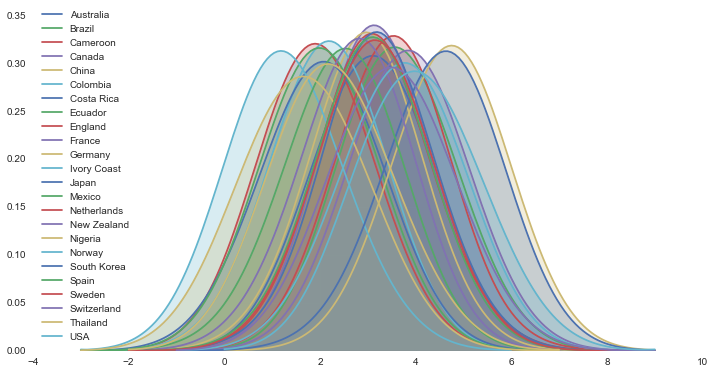

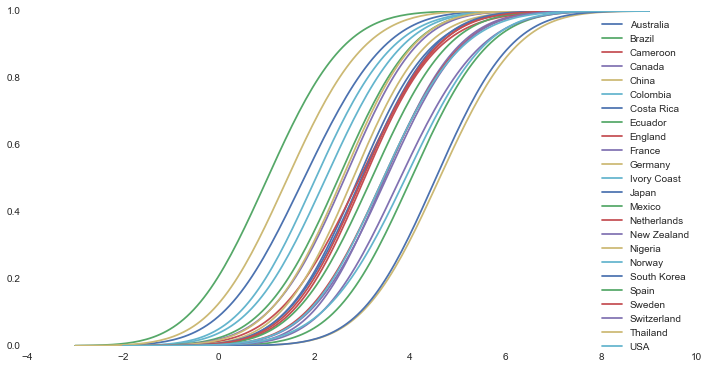

In [393]:
import matplotlib.pyplot as plt
pal = sns.color_palette(n_colors=len(fifa_score))

plt.figure(figsize=(12,6))
for i, c in zip(fifa_score.T, pal):
    sns.kdeplot(fifa_score.T[i], bw=1, label=i, color=c, shade=True)

plt.figure(figsize=(12,6))
for i, c in zip(fte_score.T, pal):
    sns.kdeplot(fte_score.T[i], bw=1, label=i, color=c, cumulative=True)    